In [70]:
import networkx as nx
import pickle
import tqdm
import pandas as pd
import logging
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
import os
from copy import copy
from networkx.algorithms import bipartite
from itertools import product, chain
from collections import Counter
# from utils import cleanCompany

import numpy as np
import gravis as gv 
import torch
import dgl

# Plotting preferences
pio.templates.default = "plotly_white"




DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [2]:
# Load dataset
from os import listdir
data_path = "C:\\Users\\jinfe\\Documents\\GitHub_dataset\\link_prediction_in_supply_chain\\USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset_20240708.csv"
interested_cols = [
    'Country',
    'Item_Tracer_Category',
    'Product_Category',
    'Product_Name',
    'UOM',
    'D365_Health_Element',
    'Illustrative_Price',
    'Ordered_Quantity'
    ]
# listdir(data_path)

us_health_commodity_df = pd.read_csv(data_path)
us_health_commodity_df.columns = us_health_commodity_df.columns.str.replace(' ', '_')
dataset = us_health_commodity_df[interested_cols]
dataset.head(3)

c:\Users\jinfe\Documents\GitHub\supply_chain\.conda\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (74,75,76,87,88,89,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Country,Item_Tracer_Category,Product_Category,Product_Name,UOM,D365_Health_Element,Illustrative_Price,Ordered_Quantity
0,Zambia,Laboratory,Laboratory Reagents,"COBAS c111 Cuvette Segments, 10 x 168, 1 Pack",UNT,HIV/AIDS,341.86,186
1,Mozambique,Laboratory,Laboratory Consumables,"Centrifuge Tube 50 mL, Polypropylene, Conical ...",UNT,HIV/AIDS,25.75,15
2,Zambia,Laboratory,Laboratory Reagents,"ABX Minotrol 16 Twin-Pack, High, 2 x 2.5 mL, 1...",PKG,HIV/AIDS,137.00,210


### create digraph with edge added

In [48]:
def sub_frame_generator(original_graph: nx.DiGraph,
                        relation_type: str,
                        src_type: str,
                        dst_type: str,
                        lookup_table: pd.DataFrame) -> pd.DataFrame:
    """
    Args:
        original_graph: Graph generated from dataset
        relation_type: Relationship type, e.g. 'buys_from'
        src_type: 'Company', 'Product', or 'Capability'
        dst_type: 'Company', 'Product', or 'Capability'
        lookup_table: lookup table parsed into function

    Returns:
        Dataframe -

        src | src_id| | dst| dst_id | relation_type | src_type | dst_type
    """
    sources_targets_nx = nx.to_pandas_edgelist(original_graph)

    empty_data_frame = pd.DataFrame({'src': [],
                                        'dst': [],
                                        'src_id': [],
                                        'dst_id': []})

    empty_data_frame['src'] = sources_targets_nx['source']
    empty_data_frame['dst'] = sources_targets_nx['target']

    mapper = dict(lookup_table[['NODE_NAME', 'NODE_ID']].values)
    empty_data_frame['src_id'] = empty_data_frame['src'].map(mapper)
    empty_data_frame['dst_id'] = empty_data_frame['dst'].map(mapper)

    # Let me know if any of the rows were not found in the mapper.
    if len(np.where(empty_data_frame.isna())[0]) > 0:
        raise Exception
    empty_data_frame = empty_data_frame.dropna()

    # Add in final pieces of information regarding relation type and src
    empty_data_frame['relation_type'] = relation_type
    empty_data_frame['src_type'] = src_type
    empty_data_frame['dst_type'] = dst_type
    return empty_data_frame



In [43]:
country_element_g =nx.from_pandas_edgelist(dataset.dropna(), 'Country', 'D365_Health_Element', create_using=nx.DiGraph()) 
element_itemC_g =nx.from_pandas_edgelist(dataset.dropna(), 'D365_Health_Element', 'Item_Tracer_Category', create_using=nx.DiGraph()) 
itemC_productC_g =nx.from_pandas_edgelist(dataset.dropna(), 'Item_Tracer_Category', 'Product_Category', create_using=nx.DiGraph()) 
product_productC_g=nx.from_pandas_edgelist(dataset.dropna(), 'Product_Category', 'Product_Name', create_using=nx.DiGraph()) 


In [60]:
country_node = pd.DataFrame({'NODE_NAME': list(set([el[0] for el in country_element_g.edges])), 'NODE_TYPE': 'COUNTRY'})
element_node = pd.DataFrame({'NODE_NAME': list(set([el[0] for el in element_itemC_g.edges])), 'NODE_TYPE': 'ELEMENT'})
itemC_node = pd.DataFrame({'NODE_NAME': list(set([el[1] for el in element_itemC_g.edges])), 'NODE_TYPE': 'ITEM_C'})
productC_node = pd.DataFrame({'NODE_NAME': list(set([el[0] for el in product_productC_g.edges])), 'NODE_TYPE': 'PRODUCT_C'})
product_node = pd.DataFrame({'NODE_NAME': list(set([el[1] for el in product_productC_g.edges])), 'NODE_TYPE': 'PRODUCT'})

country_node['NODE_ID'] = country_node.index.astype('int')
element_node['NODE_ID'] = element_node.index.astype('int')
itemC_node['NODE_ID'] = itemC_node.index.astype('int')
productC_node['NODE_ID'] = productC_node.index.astype('int')
product_node['NODE_ID'] = product_node.index.astype('int')

all_nodes_frame = pd.concat([country_node, element_node, itemC_node, productC_node, product_node ], ignore_index=True)

node_lookup_table = all_nodes_frame[['NODE_NAME', 'NODE_ID']].set_index('NODE_NAME')
node_lookup_table = node_lookup_table.reset_index()
node_lookup_table['NODE_ID'] = node_lookup_table['NODE_ID'].astype('int')

node_lookup_table

,NODE_NAME,NODE_ID
0,Liberia,0
1,Brazil,1
2,Togo,2
3,Saint Kitts and Nevis,3
4,Dominican Republic,4
...,...,...
4701,"Pregnancy Test Kit, hCG, Urine Dipstick, 25 Tests",4535
4702,(Campaign Individual) LLIN 190x180x150 cm (LxW...,4536
4703,"Chloramphenicol 250 mg Capsule, 1000 Capsules",4537
4704,"Centrifuge Tube 15 mL, Falcon Type, Blue Screw...",4538


In [65]:
country_element_g =nx.from_pandas_edgelist(dataset.dropna(), 'Country', 'D365_Health_Element', create_using=nx.DiGraph()) 
element_itemC_g =nx.from_pandas_edgelist(dataset.dropna(), 'D365_Health_Element', 'Item_Tracer_Category', create_using=nx.DiGraph()) 
itemC_productC_g =nx.from_pandas_edgelist(dataset.dropna(), 'Item_Tracer_Category', 'Product_Category', create_using=nx.DiGraph()) 
product_productC_g=nx.from_pandas_edgelist(dataset.dropna(), 'Product_Category', 'Product_Name', create_using=nx.DiGraph()) 

########################################################################
# SUB-FRAME (Country -> buy -> Element)
########################################################################
country_element_frame = \
    sub_frame_generator(country_element_g,
                        relation_type='buys',
                        src_type='COUNTRY',
                        dst_type='ELEMENT',
                        lookup_table=node_lookup_table)

########################################################################
# SUB-FRAME (element contains item category)
########################################################################
element_item_frame = (
    sub_frame_generator(element_itemC_g,
                        relation_type='element_contains',
                        src_type='ELEMENT',
                        dst_type='ITEM_C',
                        lookup_table=node_lookup_table)
)

########################################################################
# SUB-FRAME (item category contains product category)
########################################################################
item_product_frame = (
    sub_frame_generator(itemC_productC_g,
                        relation_type='item_category_contains',
                        src_type='ITEM_C',
                        dst_type='PRODUCT_C',
                        lookup_table=node_lookup_table)
)

########################################################################
# SUB-FRAME (Product category contains product)
########################################################################
product_product_frame = (
    sub_frame_generator(product_productC_g,
                        relation_type='product_category_contains',
                        src_type='PRODUCT_C',
                        dst_type='PRODUCT',
                        lookup_table=node_lookup_table)
)

triplets = pd.concat([country_element_frame, element_item_frame,  item_product_frame, product_product_frame],
                     ignore_index=True)
triplets = (triplets.reset_index(drop=True).dropna())

triplets['src_id'] = triplets['src_id'].astype('int')
triplets['dst_id'] = triplets['dst_id'].astype('int')
triplets['rel_id'] = (
    triplets['relation_type'].map({'buys': 1,
                                   'element_contains': 2,
                                   'item_category_contains': 3,
                                   'product_category_contains': 4})
)
triplets

,src,dst,src_id,dst_id,relation_type,src_type,dst_type,rel_id
0,Zambia,HIV/AIDS,73,10,buys,COUNTRY,ELEMENT,1
1,Zambia,Malaria,73,9,buys,COUNTRY,ELEMENT,1
2,Zambia,Family Planning and Reproduction,73,3,buys,COUNTRY,ELEMENT,1
3,Zambia,Maternal and Child Health,73,0,buys,COUNTRY,ELEMENT,1
4,Mozambique,HIV/AIDS,89,10,buys,COUNTRY,ELEMENT,1
...,...,...,...,...,...,...,...,...
4893,HIV Rapid Test Kits (RTKs),HIV-1 Asante Rapid Recency Assay (FOR RESEARCH...,22,1343,product_category_contains,PRODUCT_C,PRODUCT,4
4894,HIV Rapid Test Kits (RTKs),HIV-1 Asante Rapid Recency Assay (FOR RESEARCH...,22,2804,product_category_contains,PRODUCT_C,PRODUCT,4
4895,HIV Rapid Test Kits (RTKs),"HIV-1/2, Bioline 3.0, 25 Tests",22,3146,product_category_contains,PRODUCT_C,PRODUCT,4
4896,HIV Rapid Test Kits (RTKs),"HIV-1/2, STAT-PAK Assay, 20 Tests",22,940,product_category_contains,PRODUCT_C,PRODUCT,4


In [128]:
cond = triplets['relation_type'] == 'buys'
buys = triplets.loc[cond]
country_buying_triples = [torch.tensor((int(src_id), int(dst_id)),
                                       dtype=torch.int32) for src_id, dst_id in zip(buys.src_id, buys.dst_id)]


cond = triplets['relation_type'] == 'element_contains'
elements = triplets.loc[cond]
element_contain_triples = [torch.tensor((int(src_id), int(dst_id)),
                                       dtype=torch.int32) for src_id, dst_id in zip(elements.src_id, elements.dst_id)]


cond = triplets['relation_type'] == 'item_category_contains'
item = triplets.loc[cond]
item_contain_triples = [torch.tensor((int(src_id), int(dst_id)),
                                       dtype=torch.int32) for src_id, dst_id in zip(item.src_id, item.dst_id)]


cond = triplets['relation_type'] == 'product_category_contains'
product = triplets.loc[cond]
product_contain_triples = [torch.tensor((int(src_id), int(dst_id)),
                                       dtype=torch.int32) for src_id, dst_id in zip(product.src_id, product.dst_id)]


data_dict = {
    ('country', 'need', 'element'): country_buying_triples,
    ('element', 'contains', 'item category'): element_contain_triples,
    ('item category', 'contains', 'product category'): item_contain_triples,
    ('product category', 'contains', 'product'): product_contain_triples
}


graph = dgl.heterograph(data_dict)
num_rels = len(graph.etypes)

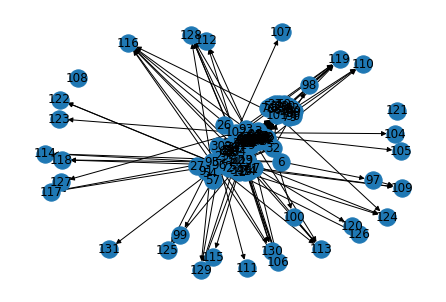

In [129]:
sub_g = dgl.edge_type_subgraph(graph, [('country', 'need', 'element'),
                                   ('element', 'contains', 'item category')])
h_sub_g = dgl.to_homogeneous(sub_g)
G = dgl.to_networkx(h_sub_g)
nx.draw(G, with_labels=True)


visualization: https://www.jianshu.com/p/767950b560c4

In [126]:
import pygraphviz as pgv
def plot_graph(nxg):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw('graph.png')

plot_graph(graph.metagraph)

country element need
element item category contains
item category product category contains
product category product contains
